# ANÁLISIS DE SINIESTRALIDAD

### CUNEF MUCD (2021/22)

- Aitor Larriona Rementería
- Diego Cendán Bedregal

## INTERPRETABILIDAD

### SHAP

Importamos las librerías necesarias para llevar a cabo este notebook

In [1]:
import pickle
import shap
import pyarrow.parquet as pq

Cargamos el modelo elegido en el notebook *03_MODELOS*.

In [2]:
with open('../Models/RF.pickle', 'rb') as f:
    RF=pickle.load(f)

Vamos a echarle un ojo al modelo para ver que efectivamente es el correcto.

In [3]:
RF

RandomForestClassifier(random_state=42)

In [4]:
shap.initjs()

In [5]:
explainer = shap.TreeExplainer(RF)

Leemos los datos de test que hemos guardado al final del notebook 02

In [6]:
table_X_test= pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big practice_data/x_test.parquet')
x_test = table_X_test.to_pandas()

Ahora, entrará en juego la variable random que hemos creado en el notebook *01_EDA*. Esta columna nos permitirá conocer la importancia de las variables cuando analicemos la interpretabilidad. Pero, ¿cómo nos va a ayudar esta variable? Cuando saquemos la importancia de variables, en alguna parte aparecerá la variable random y, todas las variables que estén por debajo de la misma no tendrán importancia ya que son menos importantes que una variable random que acabamos de crear.

### INTERPRETABILIDAD GLOBAL

La interpretabilidad global se basa en analizar la importancia que han tenido nuestras variables en el modelo de manera global, es decir, sin considerar a ningún individuo específicamente. Veamos entonces cómo hacer esto.

Debido al alto coste computacional de la función shap_values (la cual nos permitirá hallar la interpretabilidad global), utilizaremos únicamente los primeros 1000 valores del dataset x_test.

In [9]:
shap_values = explainer.shap_values(x_test.iloc[:1000,:])

Mostremos ahora las 20 variables más importantes de nuestro modelo.

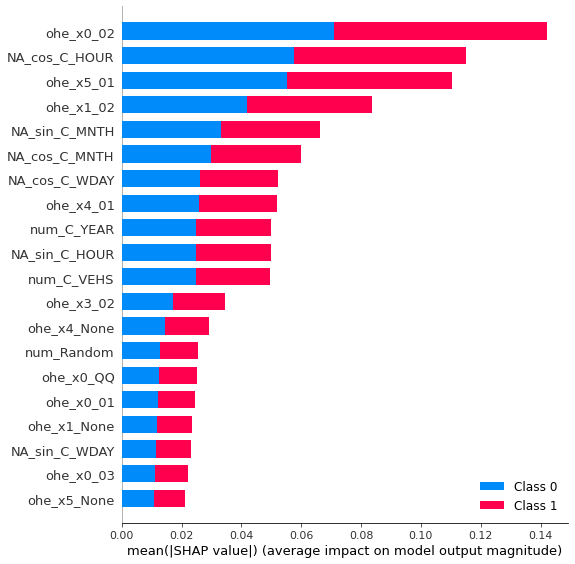

In [10]:
shap.summary_plot(shap_values, features=x_test, max_display=20)

En el gráfico que acabamos de mostrar podemos observar cuan importantes son las variables en nuestro modelo. Si nos fijamos, podemos observar que la variable random se coloca en la posición 14 más o menos con respecto la clasificación de mayor a menor importancia. Esto nos permite decidir que las variables que estén por debajo de random no aportan relevancia en nuestro modelo puesto que son menos importantes que una variable random que nos hemos inventado.

Por otro lado, las variables más importantes (ohe) se muestran a continuación:
- ohe_x0_02 = variable C_CONF con valor 02. Categorizado como *dos vehículos en movimiento en la misma dirección*.
- ohe_x5_01 = variable C_TRAF con valor 01. Categorizado como *las señales de tráfico funcionan con normalidad*.
- ohe_x1_02 = variable C_RCFG con valor 02. Categorizado como *carreteras en las existan intersecciones, o cualquier otro tipo de elemento que altere la carretera, túneles, puentes, raíles*.
- ohe_x4_01 = variable C_RALN con valor 01. Categorizado como *carreteras rectas*.

Las variables **no ohe** importantes se corresponden con las componentes seno y coseno de las variables *C_MNTH*, *C_WDAY* y *C_HOUR*. Luego, las variables que tienen que ver con el momento del accidente también son importantes.

Mostremos ahora la importancia de los valores que toman las variables, esto es, si valores altos o valores bajos de una variable aportan positiva o negativamente a valores SHAP.

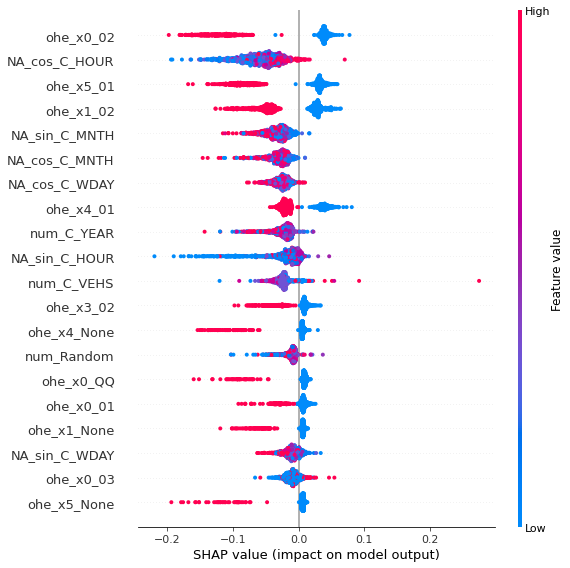

In [12]:
shap.summary_plot(shap_values[0], features=x_test.iloc[:1000,:], max_display=20)

En esta gráfica el eje de las x representa el valor del SHAP y los colores rojo y azul indican valores altos o valores bajos de la variable que estemos analizando, respectivamente.

Podemos ver qué importancia tienen las variables para los accidentes de la clase 0, esto es, la clase de los accidentes en los que hay fallecidos. Vemos que las distribuciones de importancia para las variables one hot son o bien azul o bien rojo, debido a que toman dos valores, 0 o 1. Más mezcla de valores puede apreciarse en variables continuas y entersas como son las variables coseno y seno o la variable num_C_VEHS por ejemplo.

Debemos tener en cuenta que el valor del SHAP está altamente correlacionado con el score del modelo. Esto es, valores del SHAP negativos contribuyen a un score cercano a 0 mientras que valores del SHAP más altos contribuyen a un score cercano a 1.

Por otro lado, si nos fijamos en la variable random, tenemos valores azules y rojos en el lado negativo y positivo de los valores SHAP. Esto indica que esta variable no nos aporta nada y, por ende, todas las que están debajo de ella tampoco. Por ejemplo, la variable más importante en nuestro modelo es *ohe_x0_02* y si analizamos el gráfico de importancia que acabamos de mostrar, vemos que un valor bajo de la variable contribuye positivamente hacia un valor del SHAP más alto. Esto es, si en el accidente están involucrados coches con la **no característica** de *dos vehículos en la misma dirección* aporta positivamente a que los valores SHAP sean mayores y si van dos vehículos en la misma dirección, aporta negativamente al valor SHAP.

### INTERPRETABILIDAD LOCAL

Ahora, tomaremos al azar diferentes individuos del dataset y veremos cómo lo ha clasificado el modelo y cual ha sido el peso de las variables para determinar si el indviduo ha fallecido o no.

In [20]:
choosen_instance = x_test.loc[[7493]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [ ]:
choosen_instance = x_test.loc[[7493]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Podemos ver que el individuo número 7493 del conjunto de testing ha sido clasificado en la clase 

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], features=x_test.iloc[:1000, :])

En el conjunto de variables azul comprobamos la aportación de los valores que toman diferentes variables **positivamente** al valor SHAP y, en el conjunto rojo comprobamos la aportación **negativa** al valor SHAP de los valores que toman diferentes variables.